In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.signal import butter, lfilter

In [2]:
from dspusipm import wavedump as wd

In [3]:
plt.style.use('darkside.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
fname = "/home/aj9512/jadwin-365/data/sipm/wave2.dat"

In [5]:
dt = np.dtype('<H')
file = open(fname, 'rb')
traces = np.fromfile(file, dtype=dt, count=-1)
file.close()

In [6]:
traces = traces.reshape((-1,2048)).astype(float)
tt = np.arange(0,0.004*2048,0.004)

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 250000000.0
lowcut = 1.0
highcut = 8000000.0

In [9]:
y = butter_bandpass_filter(traces[1000], lowcut, highcut, fs, order=3)

In [10]:
# plt.figure()
# plt.plot(tt, traces[1000], label='original')
# plt.plot(tt, y, label='filtered')
# plt.xlabel('Time [$\mu$s]')
# plt.ylabel('Amplitude [mV]')
# plt.xlim(2,4)
# # plt.ylim(-50, 10)
# plt.legend(loc='upper right')
# plt.show()

In [11]:
amp = [] 
integral = []

for i,wvf in enumerate(traces):
    if i % 10000 == 0:
        print(i)
    traces[i] = traces[i] - np.mean(traces[i][:100])
    traces[i] = butter_bandpass_filter(traces[i], lowcut, highcut, fs, order=3)
    amp.append(np.min(traces[i]))
    integral.append(np.sum(traces[i]))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [12]:
amp = np.array(amp)
integral = np.array(integral)

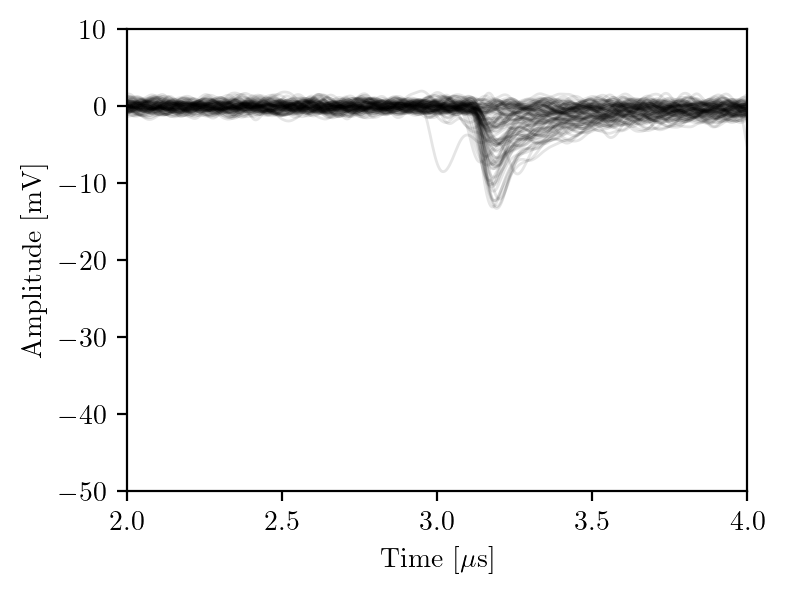

In [13]:
plt.figure()

for i,wvf in enumerate(traces[::1000]):
    plt.plot(tt, wvf, lw=1, color='k', alpha=0.1)
# plt.plot(tt, np.mean(traces, axis=0), color='r')
# plt.vlines(x=0.4*np.max(tt), ymin=-100, ymax=20, linestyles='--', lw=1)

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(2,4)
plt.ylim(-50, 10)
plt.show()

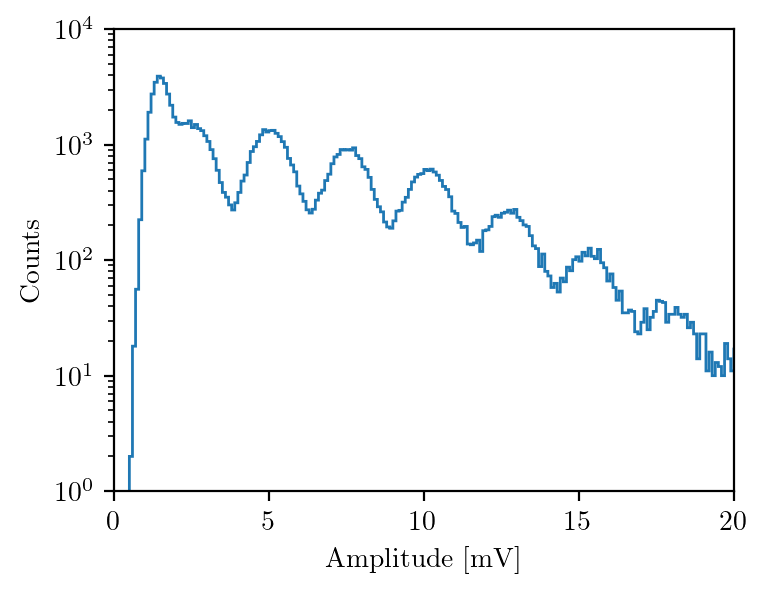

In [14]:
plt.figure()
# plt.xlim(0,80)
plt.hist(np.abs(amp), bins=np.arange(0,100,.1), histtype='step')
# plt.hist(np.abs(integral)/88, bins=np.arange(0,400,.1), histtype='step')
plt.xlabel('Amplitude [mV]')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(0,20)
plt.show()

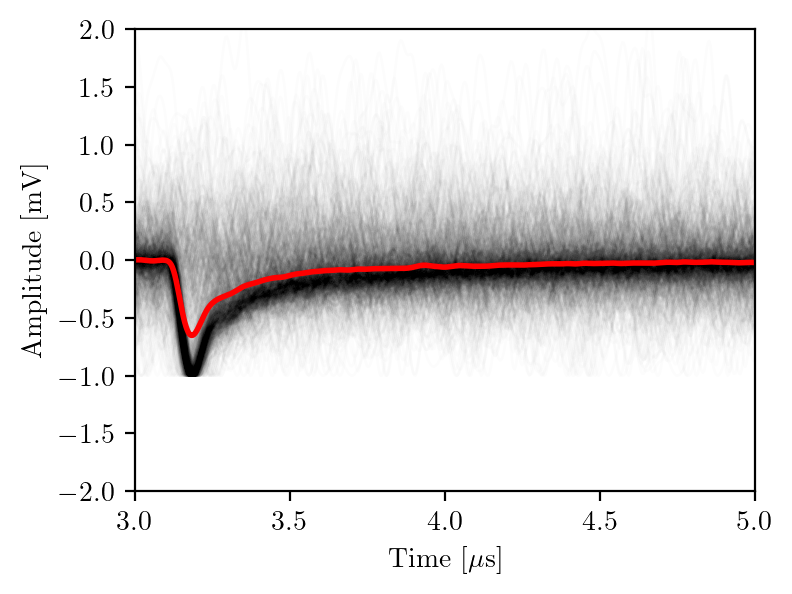

In [15]:
plt.figure()
norm_all = []
for i,wvf in enumerate(traces[::100]):
    wvf_norm = -1*wvf/np.min(wvf)
    norm_all.append(wvf_norm)
    plt.plot(tt, wvf_norm, lw=1, color='k', alpha=0.01)

mean_norm = np.mean(norm_all, axis=0)
plt.plot(tt, mean_norm, color='r')

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(0,np.max(tt))
plt.xlim(3,5)
plt.ylim(-2,2)
plt.show()

In [16]:
def func(x,a,b,c,d,e):
    return a*np.exp(-x/b)+c*np.exp(-x/d)+e
def func2(x,a,b,c):
    return a*np.exp(-x/b)+c

def func3(x,base,V0,sigma,tau,mu,tau2):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) + np.exp(0.5 * (sigma/tau2)**2 - (x-mu)/tau2))

def func4(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau))

popt2,pcov2 = curve_fit(func3, tt, -1*mean_norm, maxfev=10000, p0=[0, 1, 0.01, 0.007, 3.1, 1.], bounds=([-1,0,0,0,3,0.1],[1,2,1,1,3.5,2]))
xfit = np.linspace(0,10,100000)

plt.figure()
plt.plot(tt, -1*mean_norm, color='k')
plt.plot(xfit, func3(xfit, *popt2), color='r', ls='-', label=r"$\tau_1={:.3f}\,\mu$s, $\tau_2={:.3f}\,\mu$s".format(popt2[3], popt2[-1]), lw=1)

plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.xlim(0,np.max(tt))
plt.xlim(3,4.5)
plt.ylim(-1,1)
plt.legend(loc='upper right')
plt.show()

/tmp/ipykernel_1938855/4031359795.py:7: RuntimeWarning: overflow encountered in exp
  return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) + np.exp(0.5 * (sigma/tau2)**2 - (x-mu)/tau2))
/tmp/ipykernel_1938855/4031359795.py:7: RuntimeWarning: invalid value encountered in multiply
  return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) + np.exp(0.5 * (sigma/tau2)**2 - (x-mu)/tau2))


ValueError: array must not contain infs or NaNs